<a href="https://colab.research.google.com/github/marvelous-koala/unlimited_power/blob/master/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import pandas as pd
from google.colab import drive
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import seaborn as sns
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
raw_data = pd.read_csv('/content/drive/MyDrive/Jupyter/unlimitied_power/raw_data/train/train.csv')

In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52560 entries, 0 to 52559
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Day     52560 non-null  int64  
 1   Hour    52560 non-null  int64  
 2   Minute  52560 non-null  int64  
 3   DHI     52560 non-null  int64  
 4   DNI     52560 non-null  int64  
 5   WS      52560 non-null  float64
 6   RH      52560 non-null  float64
 7   T       52560 non-null  int64  
 8   TARGET  52560 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 3.6 MB


용어 설명
DHI : Diffuse Horizontal Irradiance (평면 산란일사량)
    대충 뭔지는 모르겠지만 일사량의 일종인 듯 하다


DNI : Diffuse Normal Irradiance (법선면 직달일사량)
    대충 이것도 일사량의 일종인 듯 하다.


WS : Wind Speepd (풍속, 단위는 초속 m/s)


RH : Relative Humidity (상대습도)


T : Temperature (기온)
다행히도 결측치는 모두 없다.

In [5]:
raw_data

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
0,0,0,0,0,0,1.5,69.08,-12,0.0
1,0,0,30,0,0,1.5,69.06,-12,0.0
2,0,1,0,0,0,1.6,71.78,-12,0.0
3,0,1,30,0,0,1.6,71.75,-12,0.0
4,0,2,0,0,0,1.6,75.20,-12,0.0
...,...,...,...,...,...,...,...,...,...
52555,1094,21,30,0,0,2.4,70.70,-4,0.0
52556,1094,22,0,0,0,2.4,66.79,-4,0.0
52557,1094,22,30,0,0,2.2,66.78,-4,0.0
52558,1094,23,0,0,0,2.1,67.72,-4,0.0


In [6]:
plots = raw_data.iloc[:,3:]
plots

,DHI,DNI,WS,RH,T,TARGET
0,0,0,1.5,69.08,-12,0.0
1,0,0,1.5,69.06,-12,0.0
2,0,0,1.6,71.78,-12,0.0
3,0,0,1.6,71.75,-12,0.0
4,0,0,1.6,75.20,-12,0.0
...,...,...,...,...,...,...
52555,0,0,2.4,70.70,-4,0.0
52556,0,0,2.4,66.79,-4,0.0
52557,0,0,2.2,66.78,-4,0.0
52558,0,0,2.1,67.72,-4,0.0


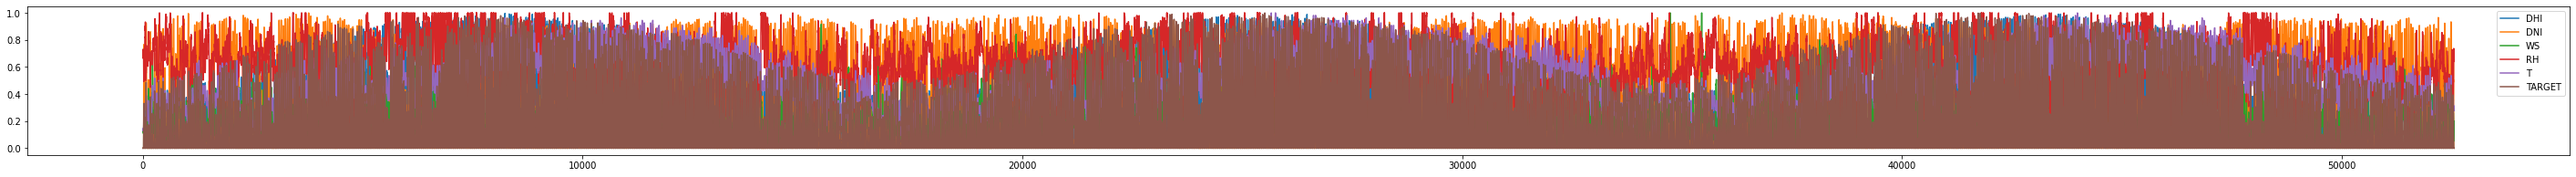

In [23]:
# 단위를 맞추기 위해 0,1로 스케일링하여 시각화해봄.
# 뭔 모양인지 모르겠음.

scaler = MinMaxScaler()
plot_scaled = pd.DataFrame(scaler.fit_transform(plots), columns=plots.columns)
plot_scaled.plot(figsize = (50,3))

DHI


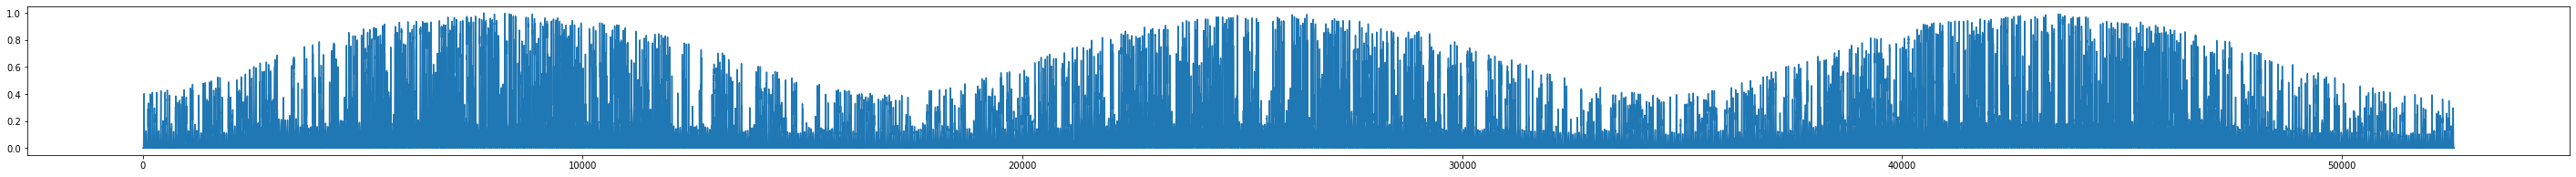

DNI


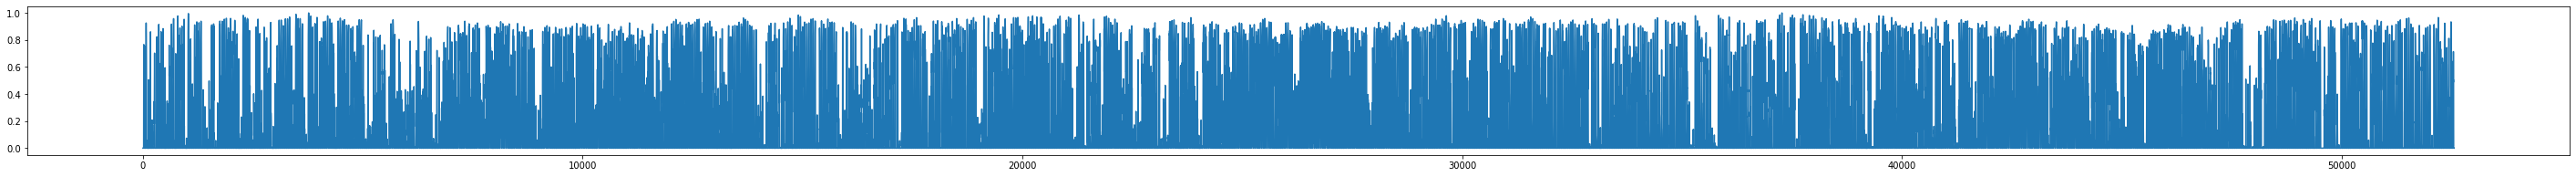

WS


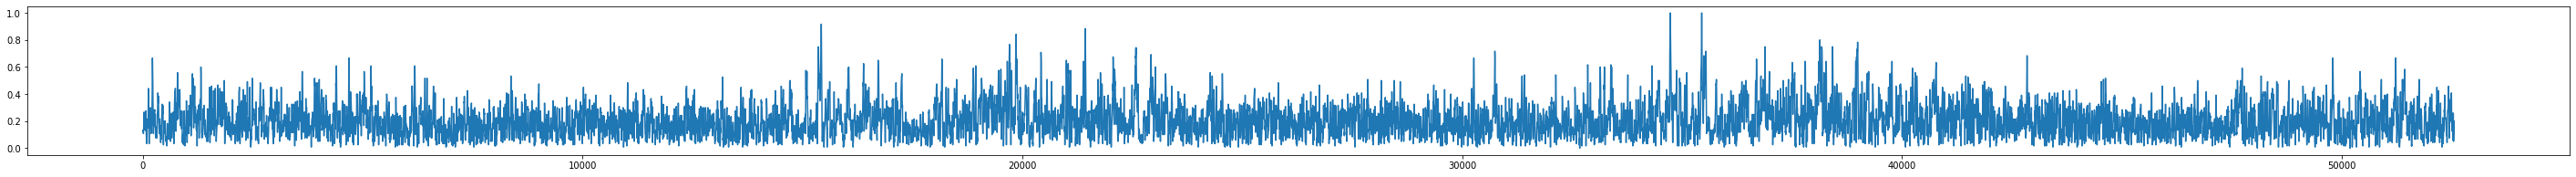

RH


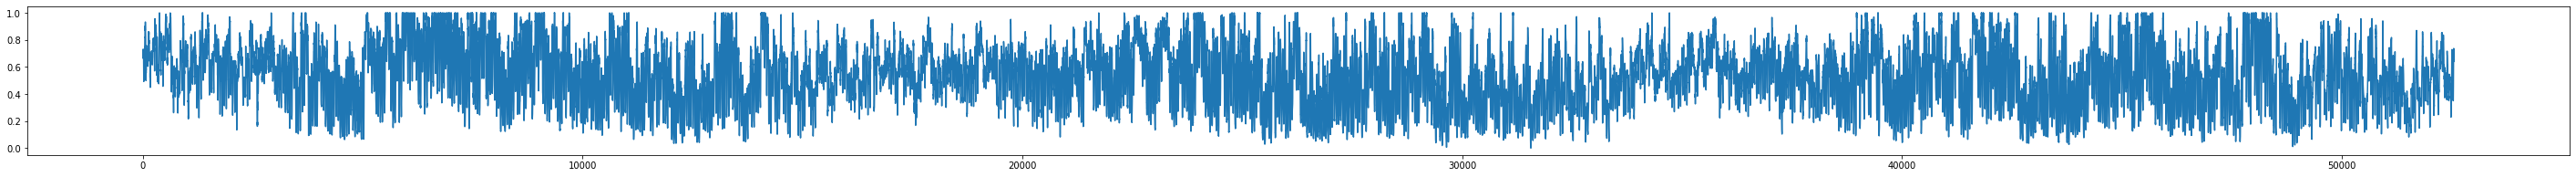

T


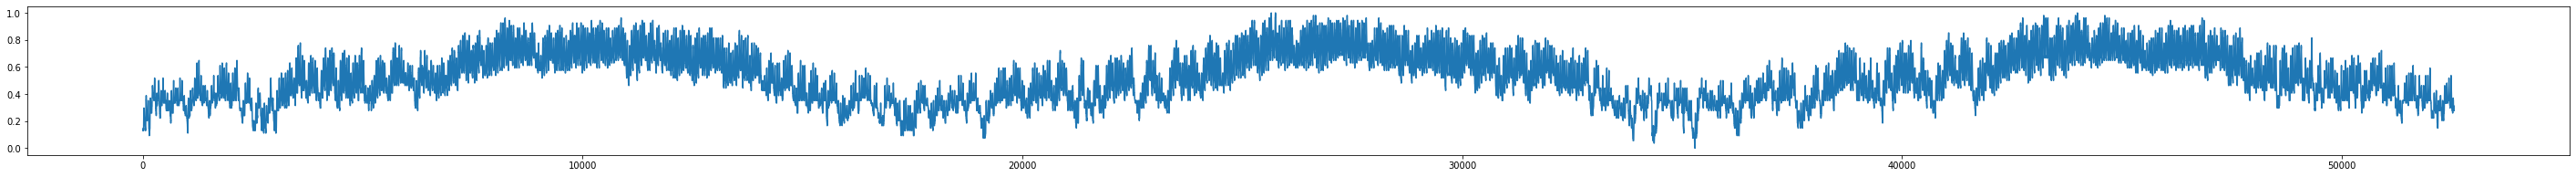

TARGET


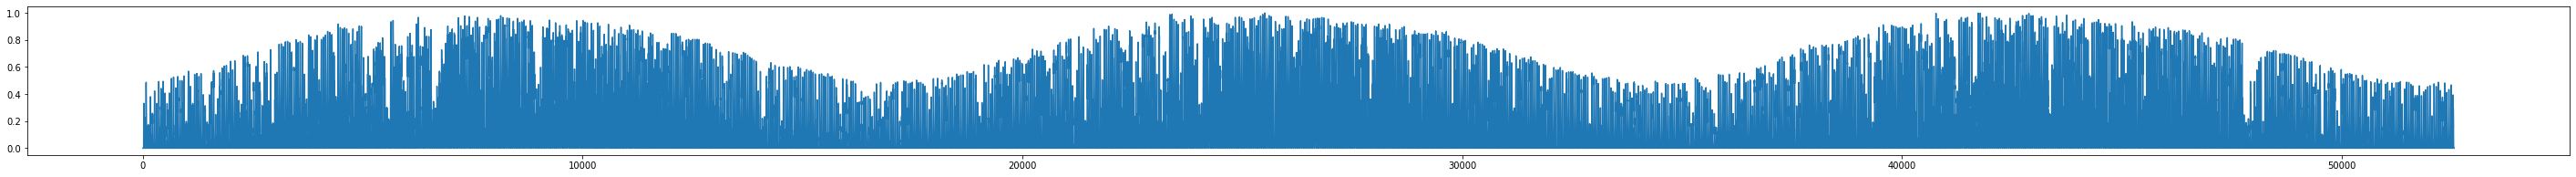

In [27]:
# 일단 마지막 타겟과 가장 유사한 모양을 보이는 것은 DHI임.\
# 대충 18,000 ~ 19,000 틱을 주기로 순환하는 모양을 보임
# 1틱 = 30분, 하루는 48틱, 나눠보면 대충 1년 주기로 순환하는 듯(당연하게도)

x = list(plot_scaled.index)

for i in plot_scaled.columns:
  print(i)
  plt.figure(figsize=(50, 3))
  plt.plot(x, plot_scaled[i])
  plt.show()

In [34]:
plot_scaled.corr()

,DHI,DNI,WS,RH,T,TARGET
DHI,1.000000,0.288294,0.203286,-0.478503,0.457813,0.666908
DNI,0.288294,1.000000,0.219555,-0.611184,0.402460,0.833547
WS,0.203286,0.219555,1.000000,-0.230035,0.027693,0.238521
RH,-0.478503,-0.611184,-0.230035,1.000000,-0.532777,-0.677178
T,0.457813,0.402460,0.027693,-0.532777,1.000000,0.561990
TARGET,0.666908,0.833547,0.238521,-0.677178,0.561990,1.000000


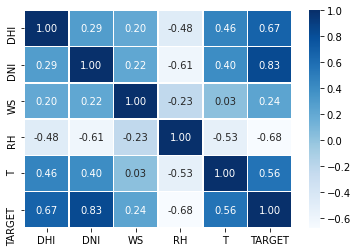

In [36]:
# 변수와 Target 사이의 상관관계(corr) 확인

sns.heatmap(data = plot_scaled.corr(), annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')

In [37]:
# 회귀분석을 돌려서 대충 어떤 요인이 중요한지 알아본다
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf

model = smf.ols(formula = 'TARGET ~ DHI + DNI + WS + RH + T', data = plots)
result = model.fit()
result.summary()

# 회귀결과 풍속(WS)는 P value 유의미하지 않음
# 5가지 변수를 알면 그날의 발전량을 90% 설명할 수 있음
# 응용해서, Target(발전량)을 예측하는 모델이 아니라, 다른 5개 변수를 예측해서 발전량을 회귀하는 모형도 가능할 듯.
############ 영향을 크게 미치는 요인, coef 절대값이 큰 순으로 온도 > DHI > DNI > RH > WS(WS는 유의미하지 못함)

# 만약에 모델링이 잘 되어서 학습시간도 줄여야 한다면, 변수간의 학습 가중치를 저런 순서로 주는 방법도 고려가 가능할 듯.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 TARGET   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                 9.452e+04
Date:                Sun, 20 Dec 2020   Prob (F-statistic):               0.00
Time:                        16:56:20   Log-Likelihood:            -1.8484e+05
No. Observations:               52560   AIC:                         3.697e+05
Df Residuals:                   52554   BIC:                         3.698e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0560      0.190     -5.552      0.000      -1.429      -0.683
DHI            0.1053      0.000    256.787      0.000       0.105       0.106
DNI            0.0488      0.000    373.885      0.000       0.048       0.049
WS            -0.0117      0.026     -0.447      0.655      -0.063       0.040
RH            -0.0255      0.002    -10.952      0.000      -0.030      -0.021
T              0.2265      0.004     51.697      0.000       0.218       0.235
==============================================================================
Omnibus:                     5583.399   Durbin-Watson:                   0.314
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            25922.073
Skew:                           0.431   Prob(JB):                         0.00
Kurtosis:                       6.331   Cond. No.                     2.29e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.29e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [38]:
## 혹시나 버릴 변수가 있는지 보기 위해 다중공선정(VIF) 검정
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

y, X = dmatrices('TARGET ~ DHI + DNI + WS + RH + T', data = plots, return_type = "dataframe")
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.round(0)

# 10을 넘으면 다중공선성 심함, 7을 넘으면 주의요망
# 현재 1~5번이 모두 1 or 2이므로 다중공선성 없음.

,VIF Factor,features
0,29.0,Intercept
1,1.0,DHI
2,2.0,DNI
3,1.0,WS
4,2.0,RH
5,2.0,T


In [30]:
# 52560/48은 총 1095일이고 이를 3으로 나누면 365다. 따라서 기막히게 3년치 자료가 주어져있음을 알 수 있따.
# 그런고로 데이터가 너무 크기 때문에 3년치로 나눈다.

k = 17520
year_1 = plot_scaled.iloc[0:k,:]
year_2 = plot_scaled.iloc[k:2*k,:]
year_3 = plot_scaled.iloc[2*k:3*k,:]